### We use icesat data for validating the dem data (tandem, aster dem, and coregistrated dem)

In [1]:
import os
root_proj = '/Users/luo/OneDrive/GitHub/Glacier-in-RGI1305'
os.chdir(root_proj)


In [2]:
import xdem
import numpy as np
import matplotlib.pyplot as plt
import h5py
from utils.raster_vec import vec2mask
from matplotlib.colors import LinearSegmentedColormap
from utils.geotif_io import readTiff
from utils.transform_xy import geo2imagexy
import statistics


In [3]:
path_tandem = 'data/dem-data/tandem-x/TDM1_DEM__30_N36E078_V01_C/DEM/TDM1_DEM__30_N36E078_DEM.tif'   # slave dem
path_dem = 'data/aster-stereo/2009-36-78/dems_2009_mosaic_subs.tif'
path_dem_aligned = 'data/aster-stereo/2009-36-78/dems_mosaic_subs_coreg.tif'
path_glah14='data/icesat/glah14-readout/GLAH14_2009_subs.H5'
path_atl06='data/icesat/atl06-readout/tile-36-78/ATL06_2020.h5'
path_water_jrc = 'data/water_jrc/water_jrc_36_78.tif'   # jrc water map for water mask
path_rgi = 'data/rgi60/rgi60_36_78.gpkg'                # rgi glacier data for glacier mask


Text(0.5, 1.0, 'dem-coreg')

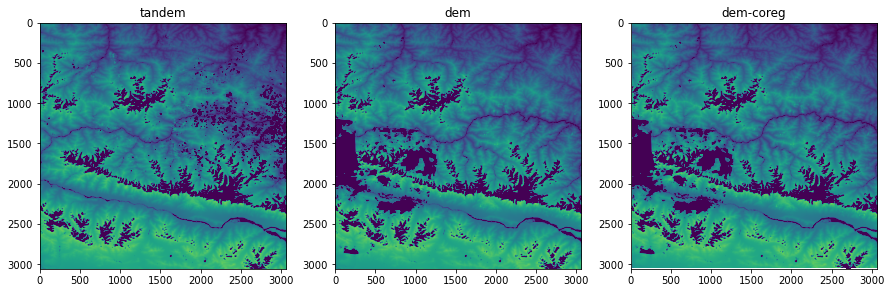

In [4]:
### 1.read dem images
dem = xdem.DEM(path_dem)        # 
dem_coreg=xdem.DEM(path_dem_aligned)
tandem = xdem.DEM(path_tandem).reproject(dem)  # resample to aster dem (30 m)
### --2.water/glacier mask
water_jrc = xdem.DEM(path_water_jrc).reproject(dem)
rgi60_mask = vec2mask(path_vec=path_rgi, path_raster=path_dem, path_save=None)
mask_img = np.where(water_jrc.data[0]+rgi60_mask==0, 1, 0)  # stable region
tandem_masked=np.copy(tandem.data[0]); tandem_masked[mask_img ==0] = 0
dem_masked=np.copy(dem.data[0]);  dem_masked[mask_img ==0] = 0
dem_coreg_masked=np.copy(dem_coreg.data[0]); dem_coreg_masked[mask_img ==0] = 0

### --3. visualize
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(tandem_masked, vmin=2000, vmax=7000); plt.title('tandem')
plt.subplot(1,3,2); plt.imshow(dem_masked, vmin=2000, vmax=7000);plt.title('dem')
plt.subplot(1,3,3); plt.imshow(dem_coreg_masked, vmin=2000, vmax=7000);plt.title('dem-coreg')


In [5]:
### Read one-year/full-region glas14/icesat data
with h5py.File(path_glah14, 'r') as f_glas14:
    glas14_lat = f_glas14['h_lat'][:]
    glas14_lon = f_glas14['h_lon'][:]
    glas14_h = f_glas14['h_cor'][:]
    glas14_t = f_glas14['t_dyr'][:]
    print(f_glas14.keys())

idx_tile = np.where((glas14_lat>36) & (glas14_lat<37) & (glas14_lon>78) & (glas14_lon<79))[0]
glas14_lat_tile, glas14_lon_tile = glas14_lat[idx_tile], glas14_lon[idx_tile]
glas14_h_tile, glas14_t_tile = glas14_h[idx_tile], glas14_t[idx_tile]


<KeysViewHDF5 ['h_cor', 'h_lat', 'h_lon', 'h_orbit', 'h_track', 't_dyr']>


In [6]:
### Read one-tile/one-year ATL06 data
with h5py.File(path_atl06, 'r') as f_atl06_tile:
    atl06_lat_tile   = f_atl06_tile['h_lat'][:]
    atl06_lon_tile   = f_atl06_tile['h_lon'][:]
    atl06_h_tile = f_atl06_tile['h_li'][:]
    atl06_time_tile = f_atl06_tile['t_dyr'][:]
    atl06_beam_tile = f_atl06_tile['beam_type'][:]
    atl06_spot_tile = f_atl06_tile['spot'][:]    # 1->strong; 0->weak
    atl06_rgt_tile = f_atl06_tile['rgt'][:]   
    print(f_atl06_tile.keys())
    

<KeysViewHDF5 ['beam_type', 'cycle', 'h_lat', 'h_li', 'h_lon', 'orbit_type', 'rgt', 'spot', 't_dyr']>


### visualize the icesat data on the dem image

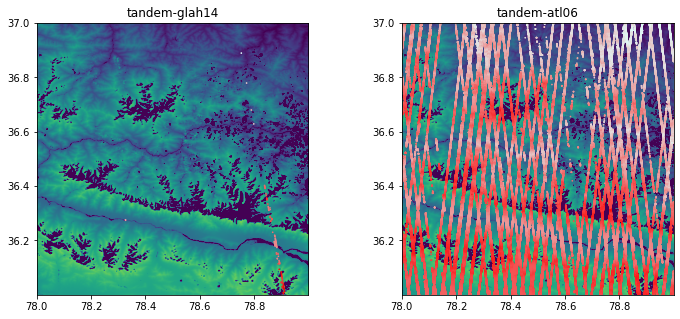

In [7]:
cmap = LinearSegmentedColormap.from_list('linear color', ['LightCyan', 'Red'])
_, dem_info = readTiff(path_dem)
extent_tandem = dem_info['geoextent']
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(tandem_masked,vmin=2000, vmax=7000, extent=extent_tandem); plt.title('tandem-glah14')
plt.scatter(x=glas14_lon_tile, y=glas14_lat_tile, c=glas14_h_tile, s=0.5, cmap=cmap)
plt.subplot(1,2,2); plt.imshow(tandem_masked,vmin=2000, vmax=7000, extent=extent_tandem); plt.title('tandem-atl06')
plt.scatter(x=atl06_lon_tile, y=atl06_lat_tile, c=atl06_h_tile, s=0.5, cmap=cmap)



### Calculate difference between the icesat data and dem image

In [23]:
### 1. icesat filter with mask image
def icesat_mask(lon, lat, h, mask, mask_geotrans):
    row, col = geo2imagexy(x=lon, y=lat, gdal_trans=mask_geotrans)
    idx_in = np.where((row<mask.shape[0]) & (col<mask.shape[1]))[0]
    row_, col_, h_ = row[idx_in], col[idx_in], h[idx_in]
    icesat_mask = mask[row_, col_]
    valid_idx = np.where((icesat_mask==1))[0]
    row_, col_, h_ = row_[valid_idx], col_[valid_idx], h_[valid_idx]
    return row_, col_, h_

glas14_row_tile_, glas14_col_tile_, glas14_h_tile_ = icesat_mask(glas14_lon_tile, \
                                        glas14_lat_tile,glas14_h_tile,mask_img,dem_info['geotrans'])

### 2. obtain height from the dem image
h_tandem_tile = tandem_masked[glas14_row_tile_, glas14_col_tile_]
h_dem_tile = dem_masked[glas14_row_tile_, glas14_col_tile_]
h_dem_coreg_tile = dem_coreg_masked[glas14_row_tile_, glas14_col_tile_]
### 3. calculate the difference between dem image and icesat data
h_dif_tandem = h_tandem_tile-glas14_h_tile_
h_dif_dem = h_dem_tile-glas14_h_tile_
h_dif_dem_coreg = h_dem_coreg_tile-glas14_h_tile_

print('tandem dif',statistics.median(h_dif_tandem))
print('dem dif',statistics.median(h_dif_dem))
print('dem_coreg dif',statistics.median(h_dif_dem_coreg))


tandem dif 0.3526611328125
dem dif -27.2205810546875
dem_coreg dif -8.86474609375


Text(0.5, 1.0, 'h_dif_dem_coreg')

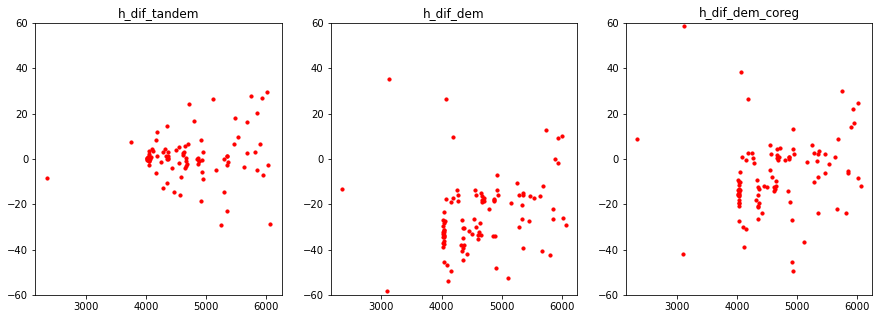

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(glas14_h_tile_, h_dif_tandem, s=10, c='Red'); 
plt.ylim(top=60, bottom=-60); plt.title('h_dif_tandem')
plt.subplot(1,3,2)
plt.scatter(glas14_h_tile_, h_dif_dem, s=10, c='Red'); 
plt.ylim(top=60, bottom=-60); plt.title('h_dif_dem')
plt.subplot(1,3,3)
plt.scatter(glas14_h_tile_, h_dif_dem_coreg, s=10, c='Red'); 
plt.ylim(top=60, bottom=-60); plt.title('h_dif_dem_coreg')



### atl06 data

In [25]:
### 1. icesat mask 
atl06_row_tile_, atl06_col_tile_, atl06_h_tile_ = icesat_mask(atl06_lon_tile, \
                                    atl06_lat_tile, atl06_h_tile, mask_img,dem_info['geotrans'])
### 2.obtain height from the dem image
h_tandem_tile = tandem_masked[atl06_row_tile_, atl06_col_tile_]
h_dem_tile = dem_masked[atl06_row_tile_, atl06_col_tile_]
h_dem_coreg_tile = dem_coreg_masked[atl06_row_tile_, atl06_col_tile_]
### calculate the difference between dem image and icesat data
h_dif_tandem = h_tandem_tile-atl06_h_tile_
h_dif_dem = h_dem_tile-atl06_h_tile_
h_dif_dem_coreg = h_dem_coreg_tile-atl06_h_tile_

print('tandem dif',statistics.median(h_dif_tandem))
print('dem dif',statistics.median(h_dif_dem))
print('dem_coreg dif',statistics.median(h_dif_dem_coreg))


tandem dif -0.4835205078125
dem dif -19.80908203125
dem_coreg dif -19.41748046875


Text(0.5, 1.0, 'h_dif_dem_coreg')

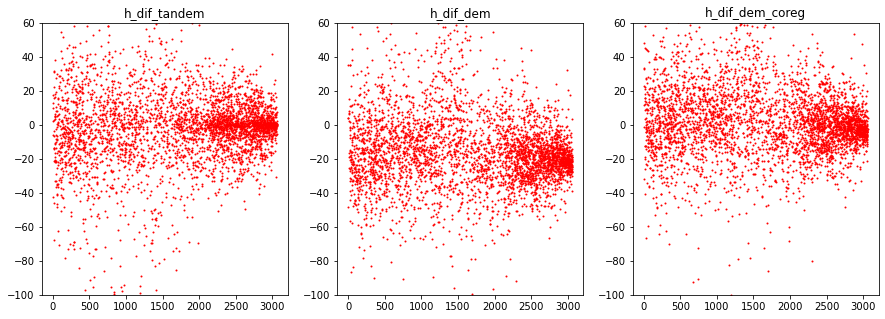

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(atl06_row_tile_[::100], h_dif_tandem[::100], s=1, c='Red'); 
plt.ylim(top=60, bottom=-100); plt.title('h_dif_tandem')
plt.subplot(1,3,2)
plt.scatter(atl06_row_tile_[::100], h_dif_dem[::100], s=1, c='Red'); 
plt.ylim(top=60, bottom=-100); plt.title('h_dif_dem')
plt.subplot(1,3,3)
plt.scatter(atl06_row_tile_[::100], h_dif_dem_coreg[::100], s=1, c='Red'); 
plt.ylim(top=60, bottom=-100); plt.title('h_dif_dem_coreg')

